Libraries
===

In [2]:
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt 
import numpy as np 
import os # accessing directory structure
import pandas as pd 
from gensim.models import Word2Vec
import re
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import seaborn as sns
from sklearn.manifold import MDS

Get stop words and punctuations of arabic
===

In [ ]:
stop_words = set(stopwords.words('arabic'))
punctuation = set(string.punctuation)
my_punctuations = {'،'}
punctuation.update(my_punctuations)
#print(stop_words)
#print(punctuation)


Sentence loader class 
====================
- i will implement as class to be iterable object because thats memory-effecient with 2 gb text data !!

Steps
---------
- Iterate over text file:
    - Open &read file
    - We split data to sentences using splitter character
    - Remove \n character from the sentences if existed after splitting
    - Iterate over lines in text:
       - This checks if the line is not empty
       - Remove the stop words:
         * concatenates WORDS With space between each 2 words 
         * we used ' ' because we split as list of words,we need to rejoin with spaces in betwenn
       - Remove punctuations: 
         * concatenates CHARACTERS WithOUT space between them
         * we used '' because we want to join characters without spaces between them (including spaces)
       - Remove numbers:
         * i tried to put my college id 
         * and notice that model will be confused when asign each dif num as a meanningfull word!
       - Get the text in a list of words
       - Reverse list because arabic reads from right to left !
         * models trained on sentences from left to right as english, french... 
         * so we need to reverse the arabic sentences to let the model learn on it in its normal order 
         * we didnot reversed each character of words because learning is usually done on words level
       - Yield line by line
         * yield is like return but for iterable objects it works as a generator to save much memory 
         * the difference is that the function using return constructs the entire list in memory and returns it
         * while using yield generates each value on the fly as i iterate over it. 
         * this makes the function using yield more memory-efficient when working with large sequences like our data :(.
         * yield will return each line and then back to the next iteration of the loop and so on.
         * return would waited for all iterations to be done then return the whole lines one time
         * thats why return would be in the end of function while yield is inside of  the loop.
         * function __iter__ expects yield

In [14]:

class AllSentences(object):
    def __init__(self, dir_name, splitter = '\n'):
        self.dirname = dir_name
        self.splitter = splitter
 
    def __iter__(self):#iteratable object
        
        for fname in os.listdir(self.dirname):
            
            with open(os.path.join(self.dirname, fname), 'r',encoding='utf-8') as file:
                text = file.read()
                
            text = text.split(self.splitter)
            if self.splitter != '\n':
                    text = [x.replace('\n', '') for x in text]
            
            for line in text:
                if line.strip():  
                   
                    line = ' '.join([word for word in line.split() if word not in stop_words])
                    
                    line = ''.join([char for char in line if char not in punctuation])
    
                    line = re.sub(r'\d+', '', line)
                    
                    line = line.split() 
                    
                    line = list(reversed(line))
    
                    yield line 

Define paths for large data and small sample data
===

In [15]:
corpus_directory_path =  'D:/MO3 LAP/Datasets/Arabic_wikipedia/arwiki_books_shards/content/sharded'

In [16]:
small_test_path= 'D:/MO3 LAP/GAN/assignment 2/small_test_directory'

Apply Text preprocessing 'Tokenization'
===

In [23]:
small_test_sentences = AllSentences(dir_name=small_test_path,splitter='\n')

In [ ]:
for sentence in small_test_sentences:
    print(sentence)

--------------------------
Parameters of Word2Vec model 
===
- I need to fully understand parameters to choose parameters making model efficient for arabic
------
 - sentences
    * my training data and word2vec will split sentences to number of 
            pairs based on window size 
 - vector_size
    * this is the dimensionality of the word vectors. 
              It determines the size of the vectors you want the model to learn 
              (size of word_embedding vector for each word), default = 100
 - window
    * this is the maximum distance between the current and predicted word within a sentence, default = 5
 - min_count
    * this ignores all words with total frequency lower than this (to ignore not important words), default = 5
 - workers
    * this is the number of worker threads used to train the model, default = 1
 - sg
    * training algorithm: 1 for skip-gram, otherwise CBOW, default is 0
 - hs
   * if 1, hierarchical softmax will be used for model training. If set to 0, and negative is non-zero,         negative sampling will be used, default is 0
 - negative:
   * if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should       be drawn (usually between 5-20). If set to 0, no negative sampling is used, default is 5
 - alpha
    * he initial learning rate, default is 0.025
 - epochs
   * number of iterations (iterations) over the corpus (whole dataset), default is 5 

----------------------------------

Train word2vec over small arabic document
===

In [25]:
small_model = Word2Vec(small_test_sentences, vector_size=2, window=3, min_count=1, workers=4, epochs=10)

Plot results
=

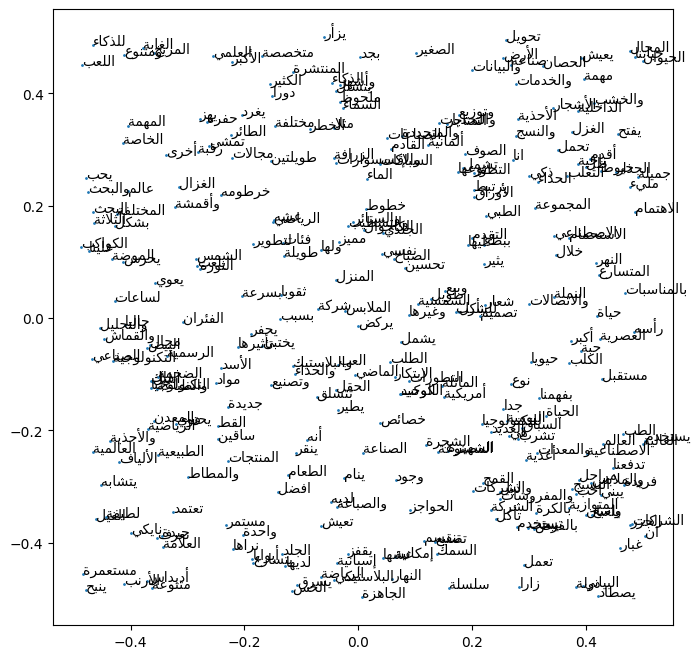

In [28]:
words = list(small_model.wv.key_to_index)# get words
vectors = [small_model.wv[word] for word in words]

plt.figure(figsize=(8, 8))
plt.scatter(*zip(*vectors), s=1)

# Annotate the points with the words
for word, vector in zip(words, vectors):
    reshaped_word = arabic_reshaper.reshape(word)#reshape the word because itis arabic :((
    bidi_word = get_display(reshaped_word)#apply the BiDi algorithm reads bidirectionally
    plt.annotate(bidi_word, vector)

plt.show()

-----------------------
Apply Tokenization over whole corpus
==

In [29]:
whole_sentences = AllSentences(dir_name=corpus_directory_path,splitter='\n')

Training big model over huge amount of data
==

In [30]:
big_model = Word2Vec(whole_sentences, vector_size=1500, window=5, min_count=8, workers=24, epochs=8)

Save model 
==

In [ ]:
big_model.save("D:/MO3 LAP/GAN/assignment 2/models/word2vec_1500vecsize_5window_8mincount_24workers_8epochs.model")

---------------
Load trained model
=

In [4]:
saved_model_path = 'D:/MO3 LAP/GAN/assignment 2/models/word2vec_1000vecsize_8window_5mincount_24workers_5epochs.model'
Trained_model = Word2Vec.load(saved_model_path)

Look at sample
=

In [5]:
simillars = Trained_model.wv.most_similar('الفضاء', topn=10)
for sim in simillars:
     #print(sim)# print words with the similarity
     print(sim[0])# print words only without the similarity



الفضاء،
للفضاء
مسبار
الفضائي
فضاء
فضاء،
المسبار
سويوز
فضائية
المريخ


In [8]:
similarity1 = Trained_model.wv.similarity('المريخ', 'الفضاء')
print(similarity1)

similarity2 = Trained_model.wv.similarity('القلم', 'الفضاء')
print(similarity2)

0.521693
-0.0017498154


Look at model parameters
=

In [29]:
print("Vectors size:",Trained_model.vector_size)
print("Window size:",Trained_model.window)
print("Total number of words:", len(Trained_model.wv))
print("Min frequency of words to be included:",Trained_model.min_count)
print("Model type:", "CBOW" if Trained_model.sg==0 else "SkipGram" )

Vectors size: 1000
Window size: 8
Total number of words: 1168811
Min frequency of words to be included: 5
Model type: CBOW


Functions For testing
=
* I canot use the Allsentences class because I want the whole doc to be tokenized as one sentnce.

In [30]:
#tokenize test docs
def tokenize_whole_doc(document,splitter='\n'):
    with open(document, 'r',encoding='utf-8') as file:
            text = file.read()
                
            text = text.split(splitter)
            if splitter != '\n':
                    text = [x.replace('\n', '') for x in text]

            tokenized_doc= []
            for line in text:
                if line.strip():  
                   
                    line = ' '.join([word for word in line.split() if word not in stop_words])
                    
                    line = ''.join([char for char in line if char not in punctuation])
    
                    line = re.sub(r'\d+', '', line)
                    
                    line = line.split() 
                    
                    line = list(reversed(line))

                    tokenized_doc.extend(line)
    return tokenized_doc

#remove words not in model
def remove_unrecognised_words(tokenized_doc,trained_model):
    for word in tokenized_doc:
        if word not in trained_model.wv:
            tokenized_doc.remove(word)
    return tokenized_doc

#convert list of words "tokens" to its embeddings
def tokens_to_embeddings(tokenized_doc,trained_model):
    vectors = [trained_model.wv[word] for word in tokenized_doc]
    return vectors

Define 2 documents paths
=
We have doc 1&2 which are very similar, also we have docs 3&4 which are less similar, also for jaccard define 2 short docs has almost same words

In [31]:
#similar docs
doc1 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc1.txt'
doc2 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc2.txt'

#less similar docs
doc3 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc3.txt'
doc4 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc4.txt'

#simi identical docs
doc5 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc5.txt'
doc6 = 'D:/MO3 LAP/GAN/assignment 2/small_test_directory/doc6.txt'


Tokenize docs
=

In [32]:
tokenized_doc1 = tokenize_whole_doc(doc1)
tokenized_doc2 = tokenize_whole_doc(doc2)

tokenized_doc3 = tokenize_whole_doc(doc3)
tokenized_doc4 = tokenize_whole_doc(doc4)

tokenized_doc5 = tokenize_whole_doc(doc5)
tokenized_doc6 = tokenize_whole_doc(doc6)

Remove words that model don't know from docs
=

In [33]:
tokenized_doc1= remove_unrecognised_words(tokenized_doc1,Trained_model)
tokenized_doc2= remove_unrecognised_words(tokenized_doc2,Trained_model)

tokenized_doc3= remove_unrecognised_words(tokenized_doc3,Trained_model)
tokenized_doc4= remove_unrecognised_words(tokenized_doc4,Trained_model)

tokenized_doc5= remove_unrecognised_words(tokenized_doc5,Trained_model)
tokenized_doc6= remove_unrecognised_words(tokenized_doc6,Trained_model)

Convert words to vectors using the trained Word2Vec
=

In [34]:
embedded_doc1 = tokens_to_embeddings(tokenized_doc1,Trained_model)
embedded_doc2 = tokens_to_embeddings(tokenized_doc2,Trained_model)

embedded_doc3 = tokens_to_embeddings(tokenized_doc3,Trained_model)
embedded_doc4 = tokens_to_embeddings(tokenized_doc4,Trained_model)

embedded_doc5 = tokens_to_embeddings(tokenized_doc5,Trained_model)
embedded_doc6 = tokens_to_embeddings(tokenized_doc6,Trained_model)

Convert to numpy array for easy manipulation
=

In [35]:
embedded_doc1 = np.array(embedded_doc1)
embedded_doc2 = np.array(embedded_doc2)

embedded_doc3 = np.array(embedded_doc3)
embedded_doc4 = np.array(embedded_doc4)

embedded_doc5 = np.array(embedded_doc5)
embedded_doc6 = np.array(embedded_doc6)

Look at shapes
=

In [36]:
print("document 1 shape:",embedded_doc1.shape)
print("document 2 shape:",embedded_doc2.shape)
print("\n")
print("document 3 shape:",embedded_doc3.shape)
print("document 4 shape:",embedded_doc4.shape)
print("\n")
print("document 5 shape:",embedded_doc5.shape)
print("document 6 shape:",embedded_doc6.shape)

document 1 shape: (27, 1000)
document 2 shape: (22, 1000)


document 3 shape: (27, 1000)
document 4 shape: (178, 1000)


document 5 shape: (12, 1000)
document 6 shape: (12, 1000)


------------------
Cosine Similarity
==
Cosine similarity is the cosine of the angle between two vectors, ranging from -1 (totally dissimilar) to 1 (tottaly similar)

We will use built-in of sklearn, it expects shape to be (num_of_samples, n_features), so our shape mow must be (1,100) 
* To calc this:
   - Get mean of vectors for each doc to convert each matrix to one vector then calc similarity between these 2 vectors.
* Note:
  in case of big documents or if u want more clear and obvious results you may need to calculate the similarity between each two sentences or paragraphs to get more accurate results, or between each word and the others, but, that's not our case now. 

In [37]:
# SIMILAR docs
mean_of_Embeddingvecs_doc1=np.mean(embedded_doc1,axis=0).reshape(1,-1)#reshape to convert (100,) to (1,100)
mean_of_Embeddingvecs_doc2=np.mean(embedded_doc2,axis=0).reshape(1,-1)
similarity_score_for_similar_docs = cosine_similarity(mean_of_Embeddingvecs_doc1, mean_of_Embeddingvecs_doc2).item()

# LESS SIMILAR docs
mean_of_Embeddingvecs_doc3=np.mean(embedded_doc3,axis=0).reshape(1,-1)#reshape to convert (100,) to (1,100)
mean_of_Embeddingvecs_doc4=np.mean(embedded_doc4,axis=0).reshape(1,-1)
similarity_score_for_less_similar_docs = cosine_similarity(mean_of_Embeddingvecs_doc3, mean_of_Embeddingvecs_doc4).item()



print("Cosine similarity between two SIMILAR documents:",similarity_score_for_similar_docs)
print("Cosine similarity between two LESS SIMILAR documents:",similarity_score_for_less_similar_docs)


Cosine similarity between two SIMILAR documents: 0.8512083292007446
Cosine similarity between two LESS SIMILAR documents: 0.5792438387870789


Report
==
As seen the cosine similarity ~= .92, thats mean 1&2 are very similar documents! and 3&4 are less similar.

----------------------
Jaccard Similarity
=
It is the size of the intersection divided by the size of the union of the sets.
It ranges from 0"no similarity" to 1"totally similar" 
* Limitations
  - Jaccard similarity only considers the presence or absence of words in sets, no looking for their order.

  - Jaccard similarity is sensitive to the size of the sets being compared.
  - Doesn't capture semantic relationships.
  - SOOOO sensitive to any little noise.

* To calculate Jaccard similarity between matrices of word embeddings, I willl follow these steps:

   - Convert the matrices into sets of unique words (vocabulary) for each document.
   - Compute the Jaccard similarity between the two sets.

In [38]:
# Step 1: Convert matrices to sets
# tuple to convert each row to object in set, tuple holds different types maybe int with string
word_set_doc1 = set(tuple(word) for word in embedded_doc1)
word_set_doc2 = set(tuple(word) for word in embedded_doc2)

word_set_doc5 = set(tuple(word) for word in embedded_doc5)
word_set_doc6 = set(tuple(word) for word in embedded_doc6)

jaccard_similarity_1_2 = len(word_set_doc1.intersection(word_set_doc2)) / len(word_set_doc1.union(word_set_doc2))
jaccard_similarity_5_6 = len(word_set_doc5.intersection(word_set_doc6)) / len(word_set_doc5.union(word_set_doc6))

print("Jaccard Similarity between 1 & 2 =",jaccard_similarity_1_2)
print("Jaccard Similarity between 5 & 6 =",jaccard_similarity_5_6)

Jaccard Similarity between 1 & 2 = 0.06521739130434782
Jaccard Similarity between 5 & 6 = 0.4666666666666667


Report
=
Even though 1&2 are so similar in meaning and have high cosine similarity, but they have low jaccard similarity value, which means they are similar in meaning not in words or vocabs that used.

--------------------
Euclidean Distance
=
it is the square root of the sum of squared differences between corresponding elements.
It ranges from 0"identical" to infinity

BUT our matrices arenot of same size "num of words" so we need to convert them to one vector with same dims...

to do so i will get the mean of each matrix "similar to cosine similarity preprocessing".

* Limitations
  - Sensitivity to scale because some values may range from 0:1 and others from 0:inf.
  - Doesn't capture semantic relationships because it will calc the distance between each dim individually then get the mean.
  - Not robust to outliers for same reason of scaling problem.
* To calculate it i will :
  - convert each matrix to its mean vector.
  - calc distance between two vectors that are with same shapes. 

In [39]:
# SIMILAR docs
mean_of_Embeddingvecs_doc1=np.mean(embedded_doc1,axis=0).reshape(-1)#reshape to convert (100,) to (100)
mean_of_Embeddingvecs_doc2=np.mean(embedded_doc2,axis=0).reshape(-1)
similarity_score_for_similar_docs = euclidean(mean_of_Embeddingvecs_doc1, mean_of_Embeddingvecs_doc2)

# LESS SIMILAR docs
mean_of_Embeddingvecs_doc3=np.mean(embedded_doc3,axis=0).reshape(-1)#reshape to convert (100,) to (100)
mean_of_Embeddingvecs_doc4=np.mean(embedded_doc4,axis=0).reshape(-1)
similarity_score_for_less_similar_docs = euclidean(mean_of_Embeddingvecs_doc3, mean_of_Embeddingvecs_doc4)



print("Eulidean Distance between two SIMILAR documents:",similarity_score_for_similar_docs)
print("Eulidean Distance between two LESS SIMILAR documents:",similarity_score_for_less_similar_docs)


Eulidean Distance between two SIMILAR documents: 6.271880626678467
Eulidean Distance between two LESS SIMILAR documents: 9.702192306518555


----------------
Bonus: Heatmaps
=

---------------
* Cosine similarity


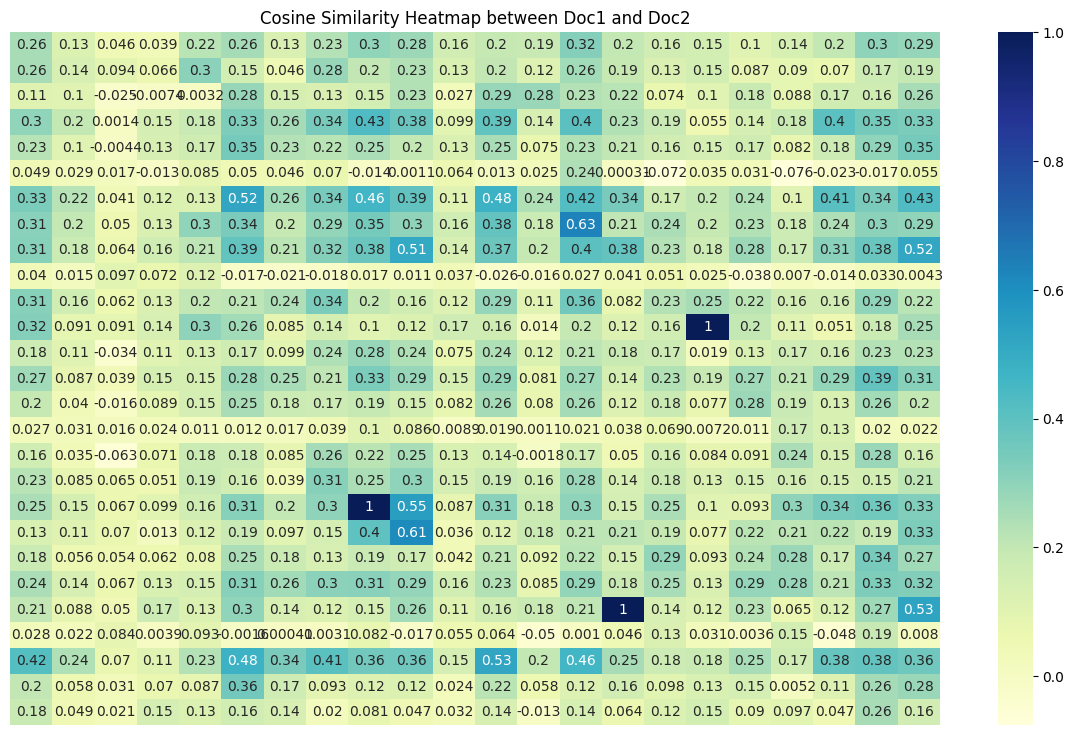

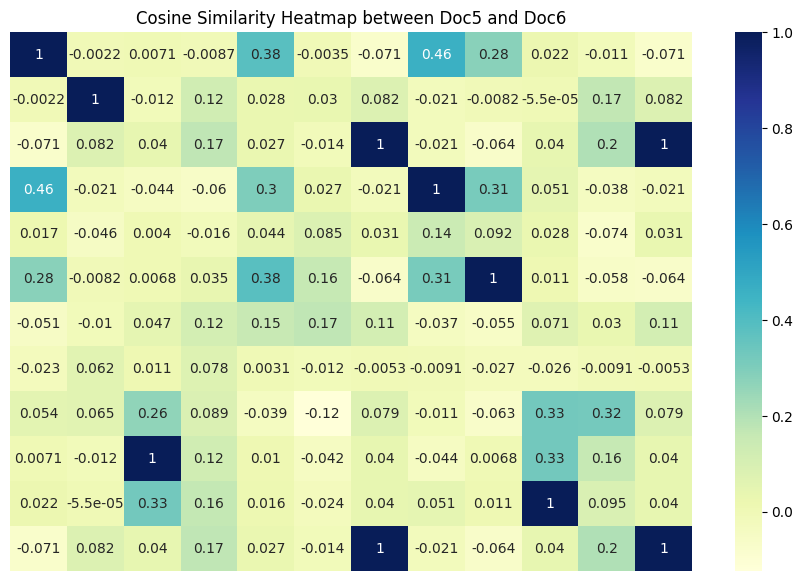

In [27]:
cosine_similarity_matrix_1_2 = np.array(cosine_similarity(embedded_doc1, embedded_doc2))

plt.figure(figsize=(15,9))
sns.heatmap(cosine_similarity_matrix_1_2,annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Heatmap between Doc1 and Doc2')
plt.show()


cosine_similarity_matrix_5_6 = np.array(cosine_similarity(embedded_doc5, embedded_doc6))

plt.figure(figsize=(11,7))
sns.heatmap(cosine_similarity_matrix_5_6, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Heatmap between Doc5 and Doc6')
plt.show()

* Eulidian distance

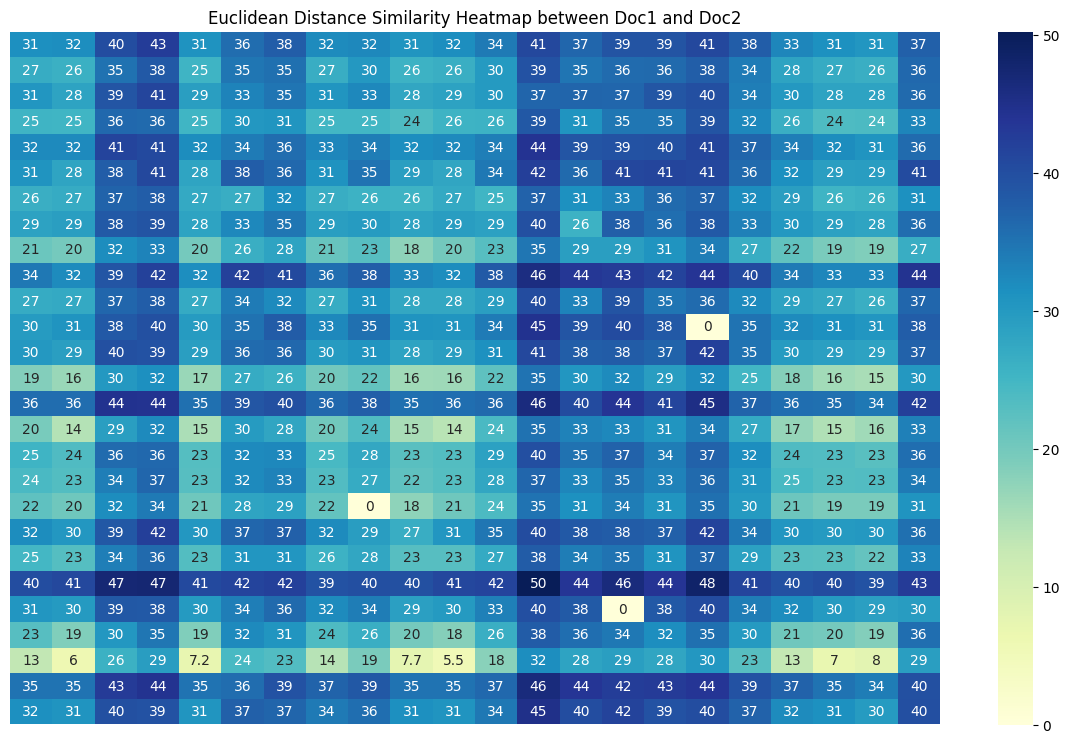

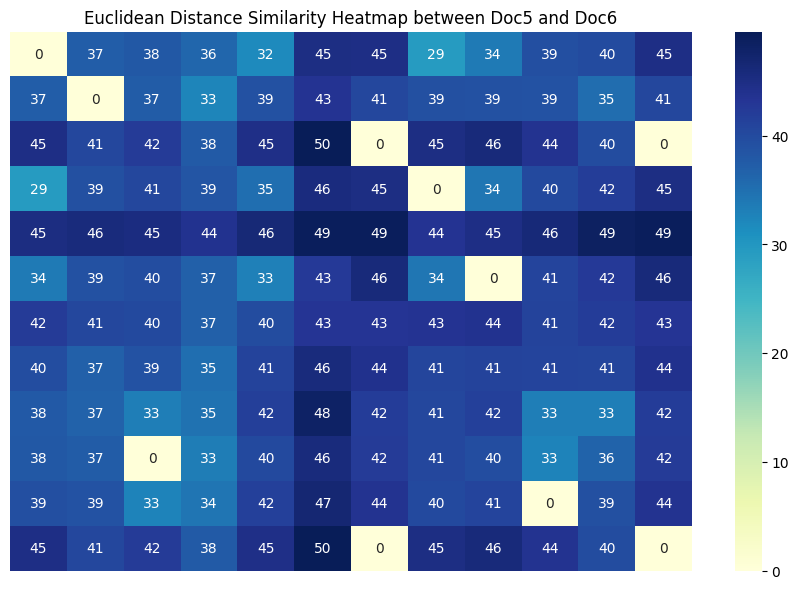

In [29]:

euclidean_distance_matrix_1_2 = np.sqrt(np.sum((embedded_doc1[:, np.newaxis, :] - embedded_doc2) ** 2, axis=-1))

plt.figure(figsize=(15, 9))
sns.heatmap(euclidean_distance_matrix_1_2, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title('Euclidean Distance Similarity Heatmap between Doc1 and Doc2')
plt.show()


euclidean_distance_matrix_5_6 = np.sqrt(np.sum((embedded_doc5[:, np.newaxis, :] - embedded_doc6) ** 2, axis=-1))

plt.figure(figsize=(11, 7))
sns.heatmap(euclidean_distance_matrix_5_6, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title('Euclidean Distance Similarity Heatmap between Doc5 and Doc6')
plt.show()


--------------
Bonus: multidimensional scaling(MDS)
=
-------------

* Cosine Similarity

c:\Users\ALMU'ATASEM HAMDI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


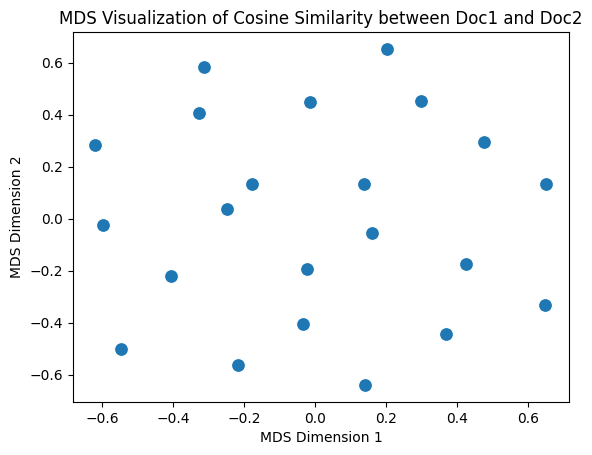

c:\Users\ALMU'ATASEM HAMDI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


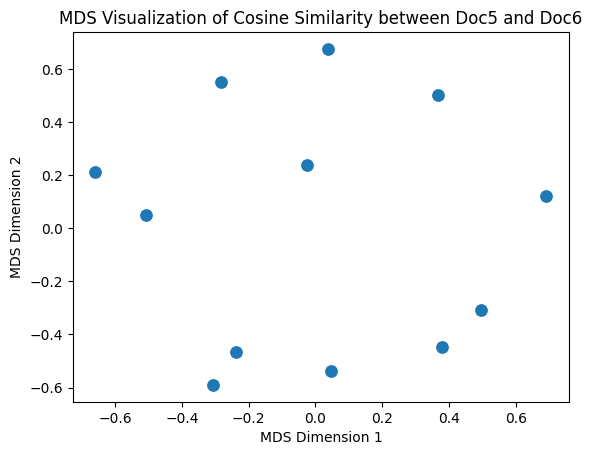

In [44]:
cosine_similarity_matrix_1_2 = np.array(cosine_similarity(embedded_doc1, embedded_doc2))
# Truncate to make it square
min_dim = min(cosine_similarity_matrix_1_2.shape[0], cosine_similarity_matrix_1_2.shape[1])
cosine_similarity_matrix_square_1_2 = cosine_similarity_matrix_1_2[:min_dim, :min_dim]
cosine_similarity_matrix_square_1_2 = 0.5 * (cosine_similarity_matrix_square_1_2 + cosine_similarity_matrix_square_1_2.T)
mds_1_2 = MDS(n_components=2, dissimilarity="precomputed", random_state=42)#precomputed similarity
coordinates = mds_1_2.fit_transform(1 - cosine_similarity_matrix_square_1_2)  # 1 minus similarity for dissimilarity
sns.scatterplot(x=coordinates[:, 0], y=coordinates[:, 1], marker='o', s=100)
plt.title('MDS Visualization of Cosine Similarity between Doc1 and Doc2')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

cosine_similarity_matrix_5_6 = np.array(cosine_similarity(embedded_doc5, embedded_doc6))
min_dim = min(cosine_similarity_matrix_5_6.shape[0], cosine_similarity_matrix_5_6.shape[1])
cosine_similarity_matrix_square_5_6 = cosine_similarity_matrix_5_6[:min_dim, :min_dim]
cosine_similarity_matrix_square_5_6 = 0.5 * (cosine_similarity_matrix_square_5_6 + cosine_similarity_matrix_square_5_6.T)
mds_5_6 = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coordinates = mds_5_6.fit_transform(1 - cosine_similarity_matrix_square_5_6)  # 1 minus similarity for dissimilarity
sns.scatterplot(x=coordinates[:, 0], y=coordinates[:, 1], marker='o', s=100)
plt.title('MDS Visualization of Cosine Similarity between Doc5 and Doc6')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()


* Euclidean Distance

c:\Users\ALMU'ATASEM HAMDI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


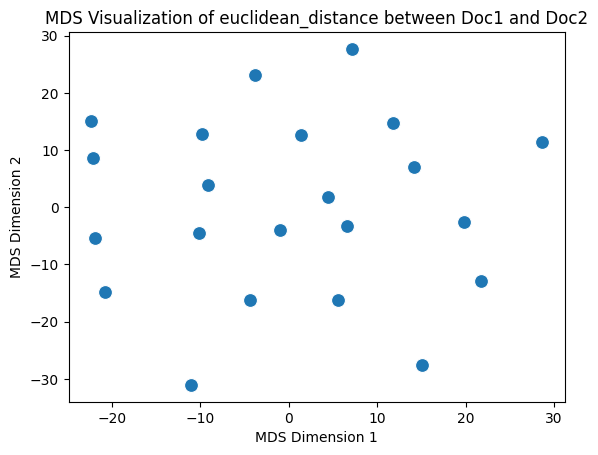

c:\Users\ALMU'ATASEM HAMDI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


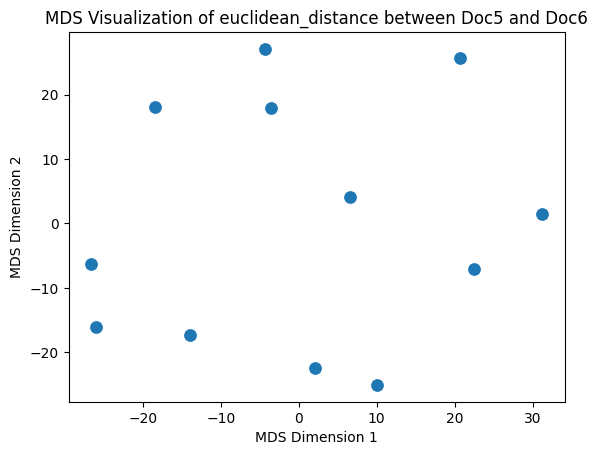

In [48]:
euclidean_distance_matrix_1_2 = np.sqrt(np.sum((embedded_doc1[:, np.newaxis, :] - embedded_doc2) ** 2, axis=-1))
min_dim = min(euclidean_distance_matrix_1_2.shape[0], euclidean_distance_matrix_1_2.shape[1])
euclidean_distance_matrix_square_1_2 = euclidean_distance_matrix_1_2[:min_dim, :min_dim]
euclidean_distance_matrix_square_1_2 = 0.5 * (euclidean_distance_matrix_square_1_2 + euclidean_distance_matrix_square_1_2.T)
mds_1_2 = MDS(n_components=2, dissimilarity="precomputed", random_state=42)#precomputed similarity
coordinates = mds_1_2.fit_transform(euclidean_distance_matrix_square_1_2)  
sns.scatterplot(x=coordinates[:, 0], y=coordinates[:, 1], marker='o', s=100)
plt.title('MDS Visualization of euclidean_distance between Doc1 and Doc2')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

euclidean_distance_matrix_5_6 = np.sqrt(np.sum((embedded_doc5[:, np.newaxis, :] - embedded_doc6) ** 2, axis=-1))
min_dim = min(euclidean_distance_matrix_5_6.shape[0], euclidean_distance_matrix_5_6.shape[1])
euclidean_distance_matrix_square_5_6 = euclidean_distance_matrix_5_6[:min_dim, :min_dim]
euclidean_distance_matrix_square_5_6 = 0.5 * (euclidean_distance_matrix_square_5_6 + euclidean_distance_matrix_square_5_6.T)
mds_5_6 = MDS(n_components=2, dissimilarity="precomputed", random_state=42)#precomputed similarity
coordinates = mds_1_2.fit_transform(euclidean_distance_matrix_square_5_6)  
sns.scatterplot(x=coordinates[:, 0], y=coordinates[:, 1], marker='o', s=100)
plt.title('MDS Visualization of euclidean_distance between Doc5 and Doc6')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()